# Guide to Orthomapping (Part 1)

Remote sensing images like a drone image, aerial photograph, or data from a satellite sensor, will inevitably be impacted by some form of geometric distortion. The shape of local terrain, the sensor angle and altitude, the motion of the sensor system, and the curvature of the Earth all make it difficult to represent three dimensional ground features accurately in a two dimensional map. For instance, distortion caused by camera tilt or terrain displacement can be seen in Fig 1 <a href='#References'>[1]</a>. The key to make a measurable, map-accurate image is to apply `Image orthorectification`, which corrects for these types of distortion <a href='#References'>[2]</a>.

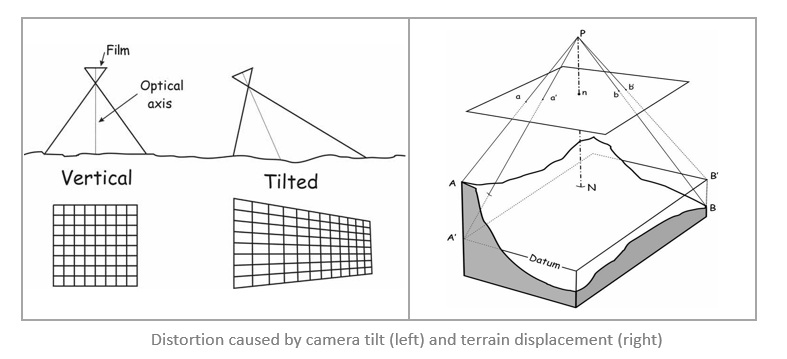

Fig 1. Distortion caused by camera tilt (left) and terrain displacement (right) (source: <a href='#References'>[1]</a>). 

`Orthomapping` is a combined process of orthorectification and mapping, in which `Orthorectification` refers to the removal of geometric distortion introduced by the platform, sensor, and especially terrain displacement, and `Mapping` refers to the edgematching, seamlines generation, and color balancing of multiple images to produce an `orthomosaic` dataset.

"This orthomosaic is accurate to a specified map scale accuracy and can be used to make measurements as well as generate and update GIS feature class layers. To accomplish this, you need imagery with known sensor positions, attitudes, and a calibrated geometric model for the sensor along with a digital terrain model (DTM)", as stated in Esri's help documentation <a href='#References'>[2]</a>. 

Orthorectified image datasets, seamless orthoimage mosaic datasets stored as a file format such as TIFF or CRF, or digital terrain models (DTM) and digital surface models (DSM) are all classified as orthomapping products <a href='#References'>[3]</a>. And the process of generating orthomapping products is summarized in the figure below.

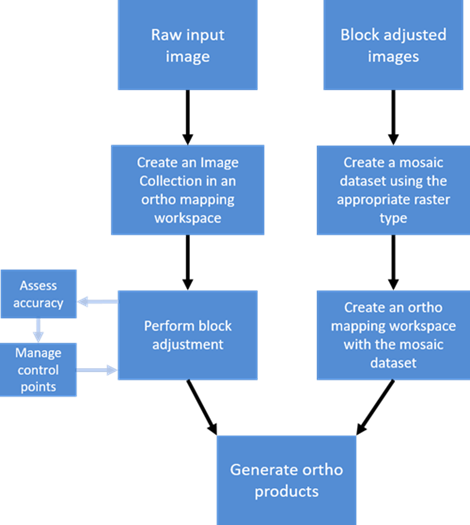

Fig 2. Workflow of generating orthomapping products (source: <a href='#References'>[3]</a>).

As for the usage of orthorectified mosaic dataset, it can be shared as dynamic image services or cached image services, or can be used to generate additional orthorectified products, such as `Image tiles`, or `Ortho image scenes` <a href='#References'>[3]</a>.

The advantage of the orthoimage is also revealed in the help documentation, that "it contains all the information visible in the imagery, not just the features and GIS layers extracted from the image and symbolized on a map" <a href='#References'>[2]</a>. One of the examples being given is that, a road symbolized on a map has uniform width, whereas a road on the orthoimage has variable width and shoulders that allow emergency vehicles to navigate traffic jams or store building material and equipment.

With your remote sensing imagery being orthorectified, and map-accurate, or other products like orthomosaics (mosaicked images corrected for distortion) and digital elevation models (terrain or surface models) created, you can then further extend their usage as basemaps, part of a landbase, or for further analysis in stereo models, 3D analysis and feature extraction <a href='#References'>[1]</a>.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Environment-Configuration" data-toc-modified-id="Environment-Configuration-1">Environment Configuration</a></span></li><li><span><a href="#Step-1.-Getting-Organized" data-toc-modified-id="Step-1.-Getting-Organized-2">Step 1. Getting Organized</a></span><ul class="toc-item"><li><span><a href="#1.1-Create-image-collection" data-toc-modified-id="1.1-Create-image-collection-2.1">1.1 Create image collection</a></span><ul class="toc-item"><li><span><a href="#1.1.1-Create-a-project-folder" data-toc-modified-id="1.1.1-Create-a-project-folder-2.1.1">1.1.1 Create a project folder</a></span></li><li><span><a href="#1.1.2-Upload-images-into-the-project-folder" data-toc-modified-id="1.1.2-Upload-images-into-the-project-folder-2.1.2">1.1.2 Upload images into the project folder</a></span></li><li><span><a href="#1.1.3-Get-image-GPS-information-and-camera-properties" data-toc-modified-id="1.1.3-Get-image-GPS-information-and-camera-properties-2.1.3">1.1.3 Get image GPS information and camera properties</a></span></li><li><span><a href="#1.1.4-Create-an-image-collection-Imagery-Layer-item" data-toc-modified-id="1.1.4-Create-an-image-collection-Imagery-Layer-item-2.1.4">1.1.4 Create an image collection Imagery Layer item</a></span></li></ul></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-3">References</a></span></li></ul></div>

## Environment Configuration

**Important Notes**: 

 - The ability to perform Orthomapping with ArcGIS Python API is available at ArcGIS Enterprise 10.6.1 through ArcGIS API for Python version 1.4.2. It is not yet available on ArcGIS Online.

 - The ArcGIS Enterprise needs to be configured with a raster analysis server, which requires an Image Server license.
 
In order to meet the requirements, your configured enterprise needs to be installed with ArcGIS Enterprise (version >= 10.6.1), and your work environment has to be installed with ArcGIS API for Python (version >= 1.4.2); also, a raster analysis server which is privileged with an Image Server license has to be federated into your configured enterprise. 

The two variables `isSupport_orthomapping` and `isSupport_rasteranalytics` will be False if failing to meet the requirements. In that case, the sample notebook cannot be continued.

In [1]:
import os
import glob
import ntpath
import arcgis
from arcgis.gis import GIS

Connect to GIS.

In [2]:
portalUrl = "https://yourportal.domain.com/portal"
portalUN = "your username"
portalPW = "your password"

gis = GIS(url=portalUrl, username=portalUN, password=portalPW)

Ensure that Orthomapping and Raster Analytics are supported in our ArcGIS Enterprise.

In [3]:
isSupport_orthomapping = arcgis.raster.orthomapping.is_supported(gis)
isSupport_orthomapping

True

In [4]:
isSupport_rasteranalytics = arcgis.raster.analytics.is_supported(gis)
isSupport_rasteranalytics

True

Now that we have a valid configured environment, let's proceed to the following four steps:
 - __Step 1. Getting Organized__, in which we will discuss how to create image collection layer item from multiple images;
 - __Step 2. Getting Adjusted__, that will introduce how to apply block adjustments, manipulate control points, and compute seamlines and color correction.
 - __Step 3. Getting Results__, in which we will talk about procedures in generating orthomosaic, DEM, and Vegetation Indices through orthomapping tools.
 - __Step 4. Managing Imageries__, that will demonstrate how to add/delete images in the image collection, and reset/delete the image collection.

## Step 1. Getting Organized

### 1.1 Create image collection

The orthomapping workflow starts from creating an image collection with the images of our study area. 

The __[arcgis.raster.analytics.create_image_collection()](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.raster.analytics.html#create-image-collection)__ task takes multiple image items as input and creates a mosaic dataset in registered raster store. Then, it creates an image collection imagery layer out of it. The function takes raster type name and raster type parameters which will be used to add images to the image collection.

Following script also shows additional steps to upload the images to the portal, get the GPS information, etc. 

#### 1.1.1 Create a project folder

In [ ]:
prjFolderName = "myOrthomappingProject"
prjFolderItem = gis.content.create_folder(folder=prjFolderName, owner=portalUN)

#### 1.1.2 Upload images into the project folder

The study site (as shown in Fig 3) has been selected at the Yucaipa Valley Water District (located at 34°00'25.6"N 117°05'47.8"W) in Calimesa, CA, and the 13 Drone images were taken here with a controlled route. Drone2Map images are placed inside the folder path `imageFolderPath` before running the cell below.

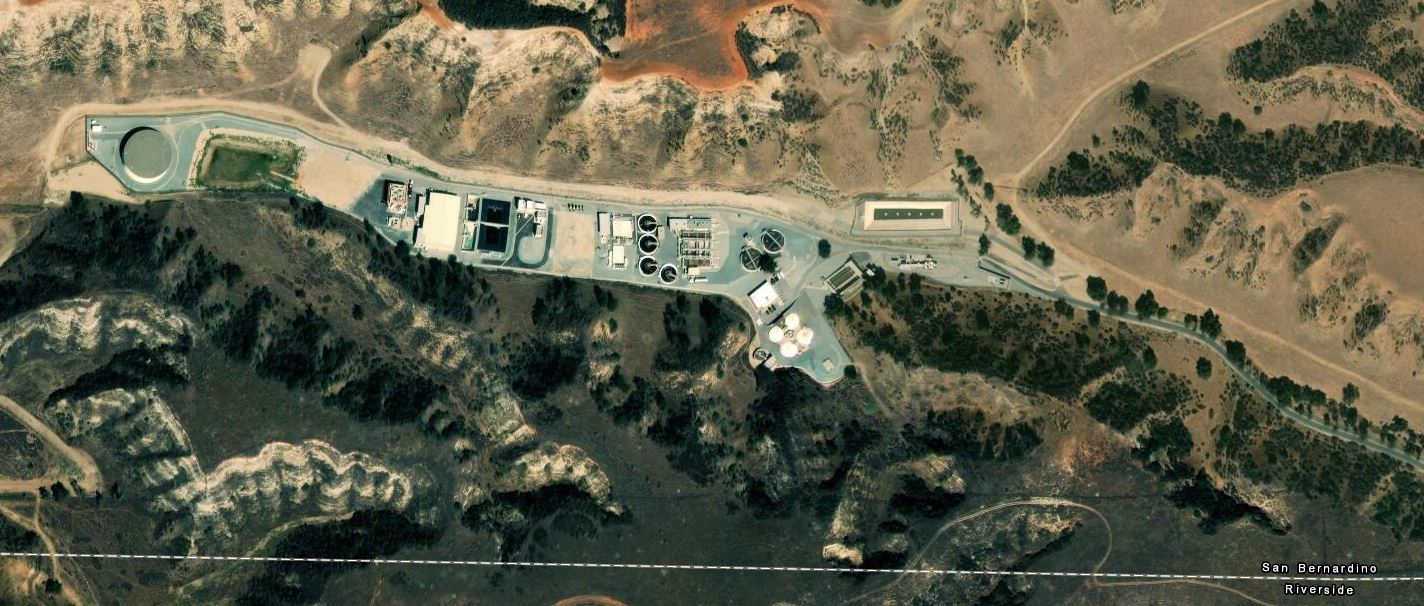
Fig 3. This layer presents low-resolution satellite imagery for the world and high-resolution satellite and aerial imagery, typically within 3-5 years of currency, for most of the world (Credits: Esri LivingAtlas)

With multiple imageries stored in a folder, the cell below is to upload the images from local folder to enterprise, and save the URL references to these uploaded images as a list variable.

In [6]:
imageFolderPath = r"\\folder\path\to\images\orthomapping\YVWD_13"
imageList = glob.glob(os.path.join(imageFolderPath, '*.JPG'))
imageItemList = []
itemPropTemplate = {"type": "Image"}

for imageFullPath in imageList:
    imageName = ntpath.split(imageFullPath)[1]
    itemPropTemplate["title"] = imageName
    itemPropTemplate["tags"] = imageName
    itemPropTemplate["description"] = imageName

    imageItem = gis.content.add(item_properties=itemPropTemplate, data=imageFullPath, owner=portalUN, folder=prjFolderName)
    imageItemList.append(imageItem)

#### 1.1.3 Get image GPS information and camera properties

Camera GPS coordinates when taking each image are needed to create image collection. This information can be stored in various image auxiliary files. For data used in this sample notebook, the GPS data is stored in EXIF (Exchangeable Image File) of the images. 

In [7]:
import exifread

The latitude is preceded by a minus sign if it is south of the equator (a positive number implies north), the longitude is preceded by a minus sign if it is west of the prime meridian (a positive number implies east), and the altitude is preceded by a minus sign if it is below sea level (a positive number implies above sea level).

In [8]:
def find_lat_long_alt_ref(tag, tags, value):
    latitude_ref = tags.get('GPS GPSLatitudeRef')
    if tag == "GPS GPSLatitude":
        if latitude_ref.values != 'N':
            value = -value
        return value
    longtitude_ref = tags.get('GPS GPSLongitudeRef')
    if tag == "GPS GPSLongitude":
        if longtitude_ref.values != 'E':
            value = -value
        return value
    altitude_ref = tags.get('GPS GPSAltitudeRef')
    if tag == "GPS GPSAltitude":
        if altitude_ref.values == 1:
            value = -value
        return value

Function to convert degrees, minutes, seconds to decimal degrees.

In [9]:
def convert_to_degrees(d,m,s):
    return d+(m/60)+(s/3600)

Function to find latitude, longitude, and altitude values.

In [10]:
def find_lat_long_alt(image, tag_ref):
    f=[]
    tags=[]
    f = open(image, 'rb')
    tags = exifread.process_file(f)
    for tag in tags:
        if tag in ('GPS GPSLatitude') and tag_ref == tag:
            lat_degree = tags[tag] 
            d = float(lat_degree.values[0].num) / float(lat_degree.values[0].den)
            m = float(lat_degree.values[1].num) / float(lat_degree.values[1].den)
            s = float(lat_degree.values[2].num) / float(lat_degree.values[2].den)
            lat_degrees = convert_to_degrees(d,m,s)
            lat_degrees = find_lat_long_alt_ref(tag, tags, lat_degrees)
            return lat_degrees
        if tag in ('GPS GPSLongitude') and tag_ref == tag:
            long_degree = tags[tag] 
            d = float(long_degree.values[0].num) / float(long_degree.values[0].den)
            m = float(long_degree.values[1].num) / float(long_degree.values[1].den)
            s = float(long_degree.values[2].num) / float(long_degree.values[2].den)
            long_degrees = convert_to_degrees(d,m,s)
            long_degrees = find_lat_long_alt_ref(tag, tags, long_degrees)
            return long_degrees
        if tag in ('GPS GPSAltitude') and tag_ref == tag:
            altitude = tags[tag] 
            altitude_meter = float(altitude.values[0].num) / float(altitude.values[0].den)
            altitude_meter = find_lat_long_alt_ref(tag, tags, altitude_meter)
            return altitude_meter

Construct the GPS array structure - [[imageName1, gpsLatitude1, gpsLongtitude1, gpsAltitude1]...]

In [11]:
gps = [[ntpath.split(image)[1], 
        find_lat_long_alt(image, 'GPS GPSLatitude'), 
        find_lat_long_alt(image, 'GPS GPSLongitude'),
        find_lat_long_alt(image, 'GPS GPSAltitude')] for image in imageList]

Construct the camera properties dictionary structure - {"maker","model","focallength","columns","rows","pixelsize"}.
We can query camera database with __[arcgis.raster.orthomapping.query_camera_info()](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.raster.orthomapping.html#query-camera-info)__

In [12]:
arcgis.raster.orthomapping.query_camera_info(camera_query="Make='Yuneec'")

,Make,Model,Focallength,Columns,Rows,PixelSize
0,Yuneec,E90,8.0,5472,3648,0.0024


In [13]:
cameraProperties = {"maker":"Yuneec","model":"E90","focallength":8,"columns":5472,"rows":3648,"pixelsize":0.0024}

**Note**: Orthomapping workflow requires to perform block adjustment for image collection at a later compute sensor model step. It relies on camera properties and camera GPS (x, y, z) when taking the images. Regarding the "z", what the underlying algorithm actually needs is the flying height information. So, it requires ground elevation data with "averagezdem" or "constantz" parameter to perform the additional subtraction.

If these "DEM" related parameters are not set, by default, it will use orthomapping elevation utility service in our ArcGIS Enterprise to perform block adjustment.

In [14]:
rasterTypeParams = {
    "gps": gps, "cameraProperties": cameraProperties, "isAltitudeFlightHeight": "False",
    "averagezdem":{
        "url":"https://elevation3d.arcgis.com/arcgis/rest/services/WorldElevation3D/Terrain3D/ImageServer"
    }
}

In [15]:
rasterTypeParams

{'gps': [['YUN_0044.JPG', 34.0070879, -117.09416449999999, 725.18],
  ['YUN_0045.JPG', 34.007113099722226, -117.09450929972222, 725.36],
  ['YUN_0046.JPG', 34.0071384, -117.09485779972222, 725.21],
  ['YUN_0076.JPG', 34.00668639972222, -117.09463709972222, 725.37],
  ['YUN_0077.JPG', 34.00666089972222, -117.09428809972222, 725.31],
  ['YUN_0078.JPG', 34.00663709972222, -117.09395939999999, 725.23],
  ['YUN_0079.JPG', 34.0066113, -117.09360669972222, 725.31],
  ['YUN_0080.JPG', 34.00658549972222, -117.09325299999999, 725.35],
  ['YUN_0081.JPG', 34.0065606, -117.0929043, 725.18],
  ['YUN_0040.JPG', 34.0069887, -117.09279029999999, 725.13],
  ['YUN_0041.JPG', 34.0070131, -117.09311519972222, 725.0],
  ['YUN_0042.JPG', 34.0070381, -117.09346329972222, 725.12],
  ['YUN_0043.JPG', 34.00706339972222, -117.09381479999999, 725.2]],
 'cameraProperties': {'maker': 'Yuneec',
  'model': 'E90',
  'focallength': 8,
  'columns': 5472,
  'rows': 3648,
  'pixelsize': 0.0024},
 'isAltitudeFlightHeight': 

#### 1.1.4 Create an image collection Imagery Layer item

In [16]:
from arcgis.raster.analytics import create_image_collection
imagecollectionName = "omImageCollection"
imagecollectionItem = create_image_collection(image_collection=imagecollectionName,
                                              input_rasters=imageItemList,
                                              raster_type_name="UAV/UAS",
                                              raster_type_params=rasterTypeParams,
                                              folder=prjFolderName)

In [1]:
imagecollectionItem.url

'https://yourportal.domain.com/server/rest/services/Hosted/omImageCollection/ImageServer'

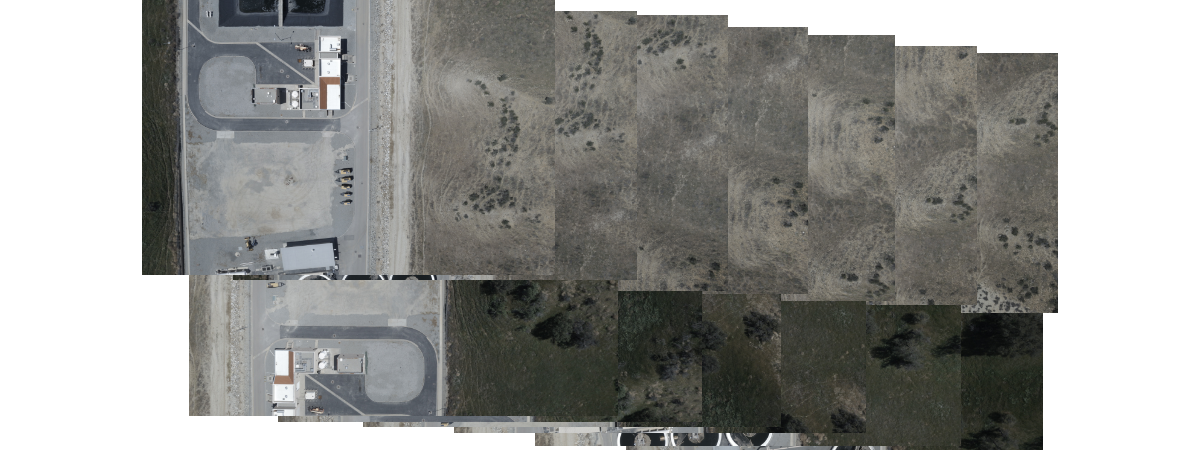

In [18]:
imagecollectionItem.layers[0]

Now we have finished creating an Imagery Collection Layer Item, let's move onto Step 2 (Getting Adjusted) and Step 3 (Getting Results) in <a href='orthomapping_guide_2.ipynb'>Part 2</a>.

## References

<a href="#Guide-to-Orthomapping-(Part-1)">[1]</a> Lenhardt & Liedtke, Ortho Mapping in ArcGIS Pro Part I: Getting Organized with a Workspace, https://www.esri.com/arcgis-blog/products/arcgis-pro/imagery/ortho-mapping-workspace/ [Online] [Assessed on August 13, 2019]

<a href="#Guide-to-Orthomapping-(Part-1)">[2]</a> Introduction to orthomapping, https://pro.arcgis.com/en/pro-app/help/data/imagery/introduction-to-ortho-mapping.htm [Online] [Assessed on August 9, 2019]

<a href="#Guide-to-Orthomapping-(Part-1)">[3]</a> Ortho mapping in ArcGIS Pro, https://pro.arcgis.com/en/pro-app/help/data/imagery/ortho-mapping-in-arcgis-pro.htm [Online] [Assessed on August 13, 2019]